# PLS Regression

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data

X, Y, demographics = get_data()
ages, sexes = demographics['Age'], demographics['Sex']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Sex: {sexes.shape}')

X: (390, 34716) | Y: 16 | Age: (390,) | Sex: (390,)


In [12]:
selected_target = "WISC_VSI"
y = Y[selected_target]

print(f'y: {y.shape}')

y: (390,)


## Feature selection

### Age Binning

In [13]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages, y)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 0 Range: 6.03 -> 8.98
Bin 1 Range: 9.04 -> 11.96
Bin 2 Range: 12.03 -> 15.98
---
Bin 0 Range: 64.00 -> 147.00
Bin 1 Range: 57.00 -> 144.00
Bin 2 Range: 57.00 -> 155.00
---
Bin 1: (117, 34716) | Bin 2: (156, 34716) | Bin 3: (117, 34716)


## PLS Regression Model

In [5]:
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_validate, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### Set up the model pipeline, metrics, and cross-validation approach

In [6]:
def regression_scorer(reg, X, y):
    y_pred = reg.predict(X)[:, 0]
    return stats.pearsonr(y, y_pred)[0]

estimators = [StandardScaler(), PLSRegression(n_components=4)]
pipe = make_pipeline(*estimators)

scoring = ['train_score', 'test_score']
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=251183)

### Run cross-validation

In [17]:
%%time
# X_cv = bin_3[0]
# y_cv = bin_3[1]
X_cv = X
y_cv = y

scores = cross_validate(pipe, X_cv, y_cv, cv=rkf, scoring=regression_scorer, n_jobs=-1, 
                        return_train_score=True, return_estimator=True)

coefs = [estimator['plsregression'].coef_ for estimator in scores['estimator']]
avg_coef = np.mean(coefs, axis=0)[:, 0]

print(f'Target: {selected_target}')
for metric in scoring:
    metric_values = scores[metric]
    print(f'Avg {metric}: {np.mean(metric_values):.2f}')

Target: WISC_FSIQ
Avg train_score: 0.85
Avg test_score: 0.36
CPU times: user 115 ms, sys: 273 ms, total: 387 ms
Wall time: 2.81 s


In [26]:
from common.paths import PLS_WEIGHTS

np.save(PLS_WEIGHTS, avg_coef)

### Run permutation statistic

In [ ]:
%%time
X_cv = bin_1[0]
y_cv = bin_1[1]
# X_cv = X
# y_cv = y

score, permutation_scores, pvalue = permutation_test_score(
    pipe, X_cv, y_cv, cv=rkf, scoring=regression_scorer, n_permutations=3000, n_jobs=-1)

print(f'Target: {selected_target}')
print(f'Score: {score:.2f} | p-value: {pvalue:.4f}')

## Analyze PLS Coefficients

### Compare ages

In [36]:
from common.calculation import (
    calc_cosine_similarity, calc_norm_euclidean, compare_age_similarity)
from common.plotting import plot_age_comparisons

In [56]:
all_ages_s, bin_1_s, bin_2_s, bin_3_s = np.clip(all_ages, np.min(all_ages), 0), np.clip(bin_1, np.min(bin_1), 0), np.clip(bin_2, np.min(bin_2), 0), np.clip(bin_3, np.min(bin_3), 0)

[[1.         0.10837503 0.07464222 0.02468051]
 [0.10837503 1.         0.03270236 0.01762623]
 [0.07464222 0.03270236 1.         0.03451587]
 [0.02468051 0.01762623 0.03451587 1.        ]]


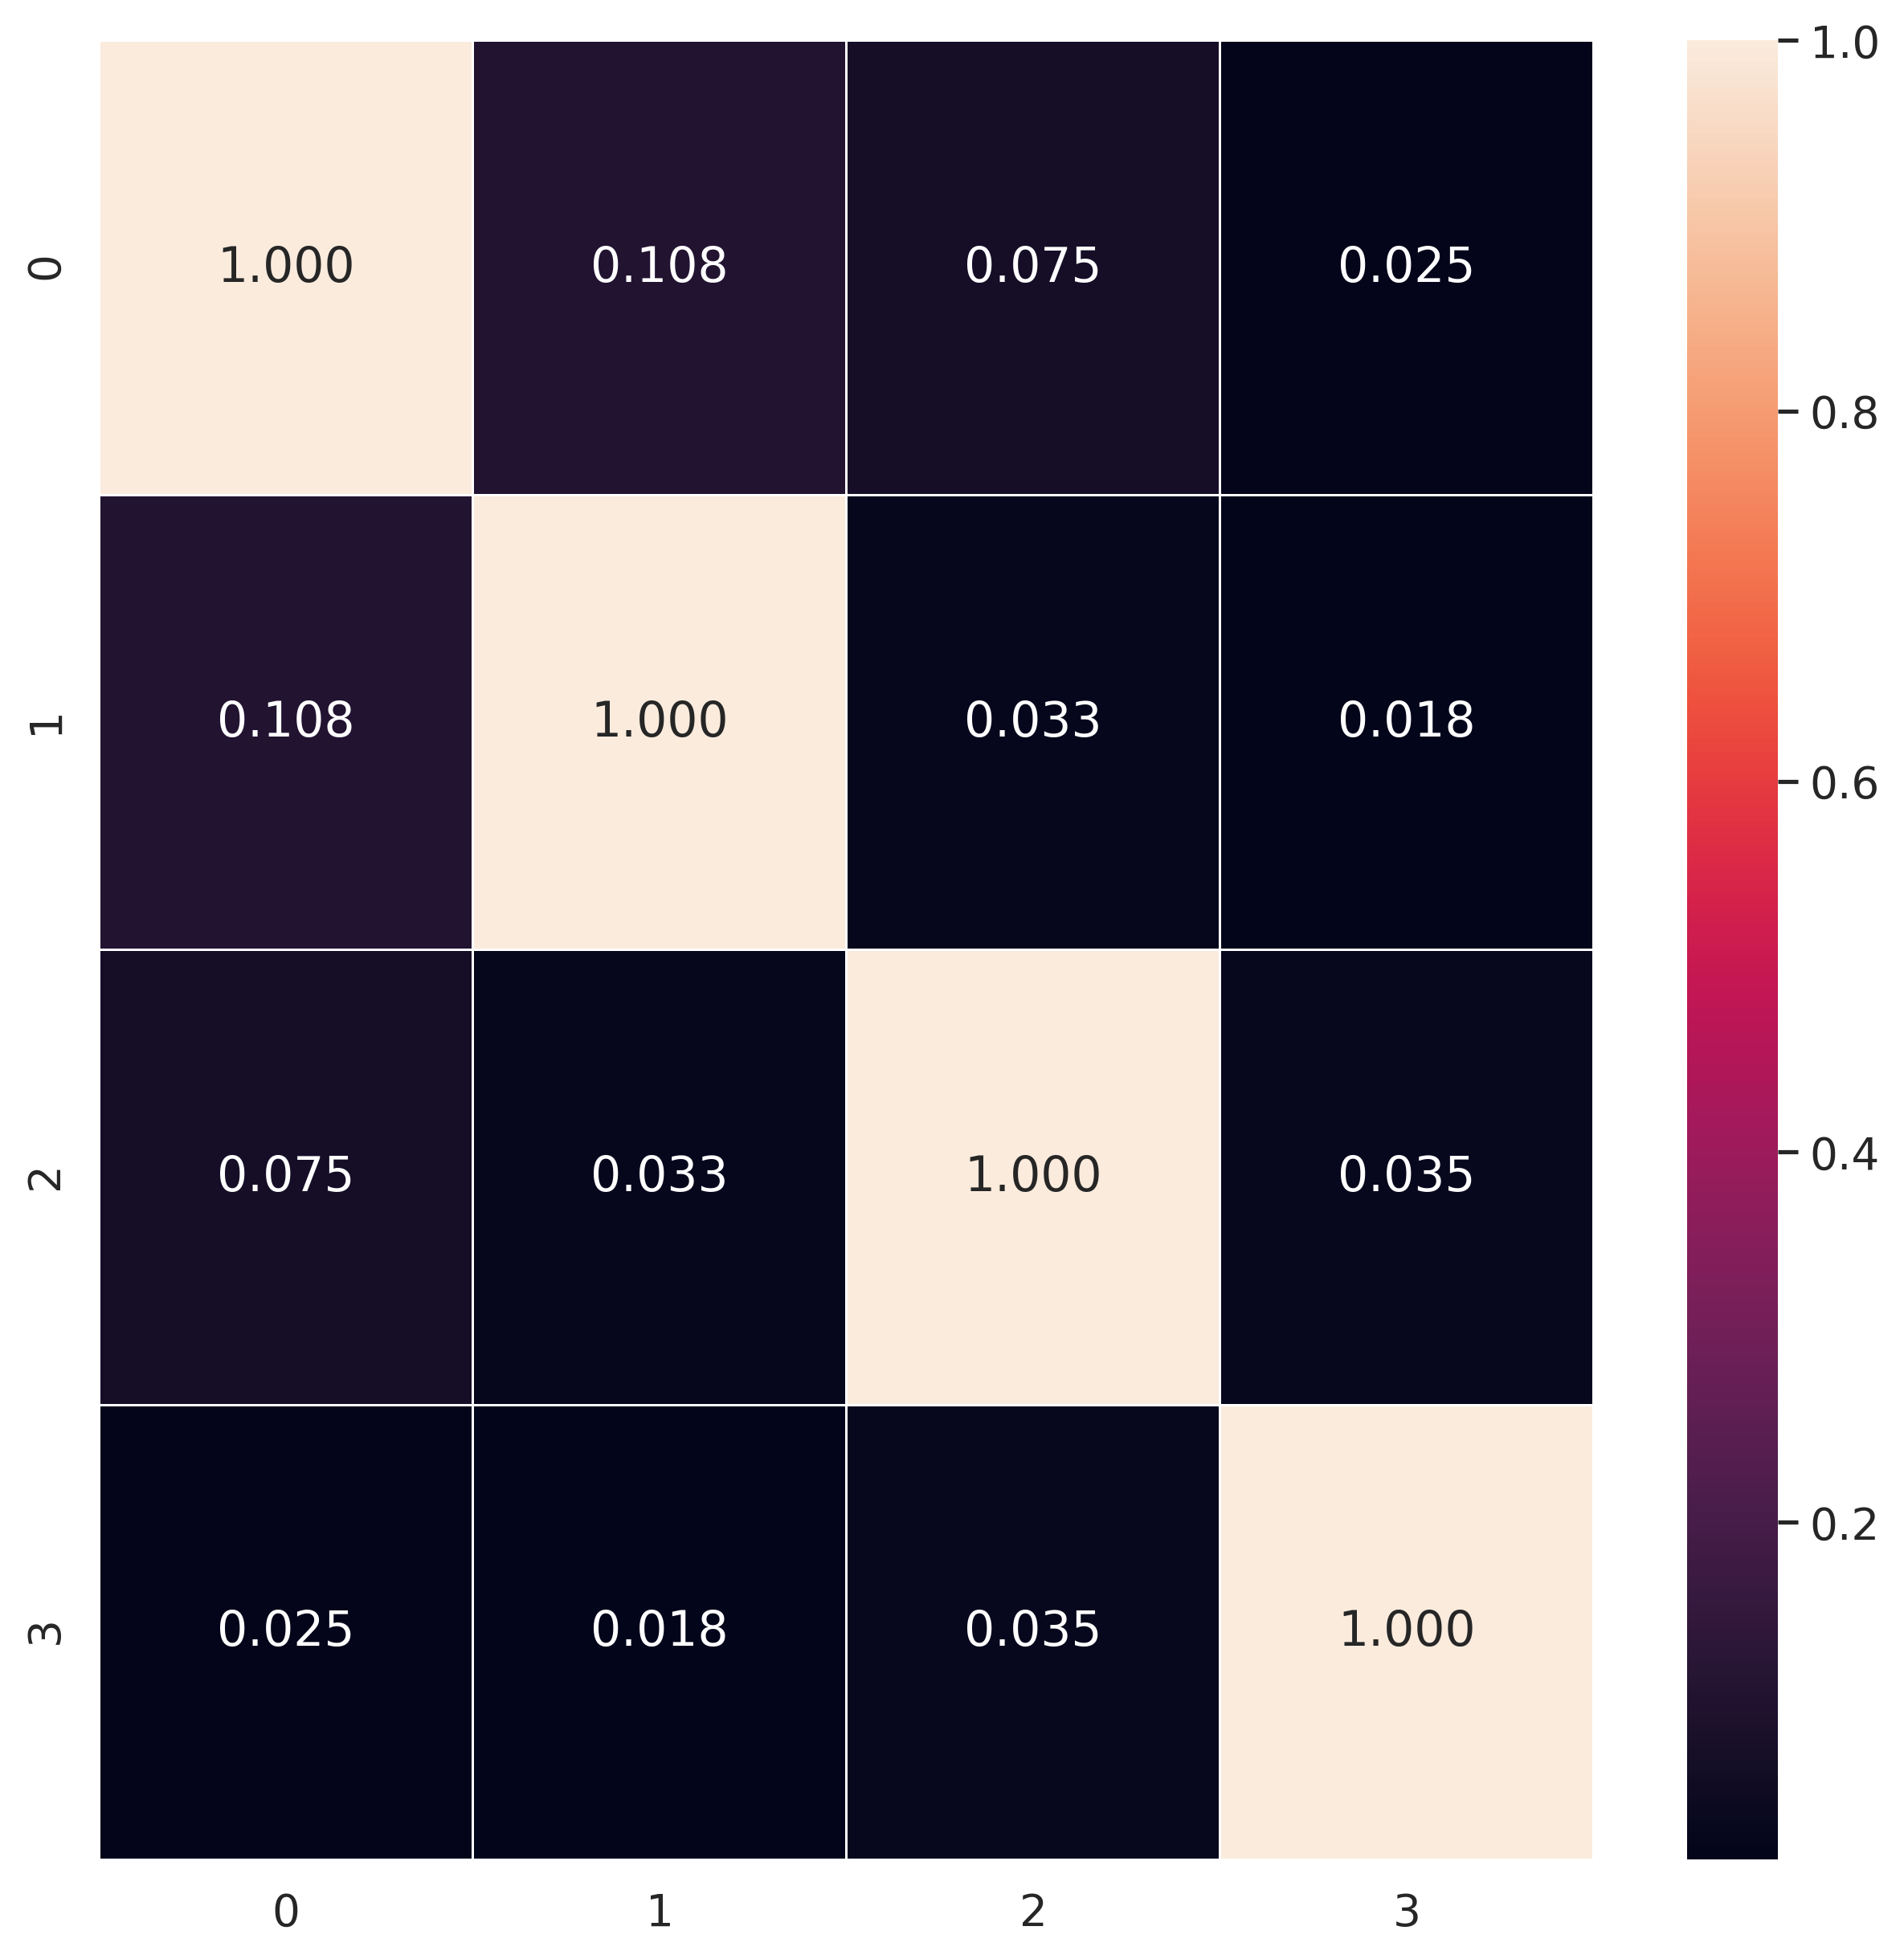

In [57]:
comparisons = compare_age_similarity(all_ages_s, bin_1_s, bin_2_s, bin_3_s, calc_cosine_similarity)
np.fill_diagonal(comparisons, 1)
print(comparisons)
plot_age_comparisons(comparisons)

In [51]:
distance_func = stats.spearmanr

print(distance_func(all_ages, bin_1))
print(distance_func(all_ages, bin_2))
print(distance_func(all_ages, bin_3))
print(distance_func(bin_1, bin_2))
print(distance_func(bin_1, bin_3))
print(distance_func(bin_2, bin_3))

SpearmanrResult(correlation=0.04839780724742265, pvalue=1.8375564055331053e-19)
SpearmanrResult(correlation=0.06770822451095877, pvalue=1.4502789570195166e-36)
SpearmanrResult(correlation=0.02549822337249106, pvalue=2.019240964563468e-06)
SpearmanrResult(correlation=0.011898695973375492, pvalue=0.02662370222138213)
SpearmanrResult(correlation=0.0055914921018586205, pvalue=0.2975089091639709)
SpearmanrResult(correlation=0.003062358126750857, pvalue=0.5682935956922676)
